In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
import numpy as np
from epi.models import Parameter, Model
from epi.util import pairplot

### 1. Define the V1Circuit model

In [164]:
lb = -10.
ub = 10.

sW_P = Parameter("sW_P", 1, lb=lb, ub=ub)
sW_A = Parameter("sW_A", 1, lb=lb, ub=ub)

vW_PA = Parameter("vW_PA", 1, lb=lb, ub=ub)
vW_AP = Parameter("vW_AP", 1, lb=lb, ub=ub)

dW_PA = Parameter("dW_PA", 1, lb=lb, ub=ub)
dW_AP = Parameter("dW_AP", 1, lb=lb, ub=ub)

hW_P = Parameter("hW_P", 1, lb=lb, ub=ub)
hW_A = Parameter("hW_A", 1, lb=lb, ub=ub)

"""sW_P = Parameter("sW_P", 1, lb=2*lb, ub=0.)
sW_A = Parameter("sW_A", 1, lb=2*lb, ub=0.)

vW_PA = Parameter("vW_PA", 1, lb=3*lb, ub=0.)
vW_AP = Parameter("vW_AP", 1, lb=3*lb, ub=0.)

dW_PA = Parameter("dW_PA", 1, lb=lb, ub=ub)
dW_AP = Parameter("dW_AP", 1, lb=lb, ub=ub)

hW_P = Parameter("hW_P", 1, lb=2.*lb, ub=0.)
hW_A = Parameter("hW_A", 1, lb=2.*lb, ub=0.)"""

parameters = [sW_P, sW_A, vW_PA, vW_AP, dW_PA, dW_AP, hW_P, hW_A]

model = Model("SC_Circuit", parameters)

In [194]:
import tensorflow as tf
DTYPE = tf.float32

t_cue_delay = 1.2
t_choice = 0.6
t_total = t_cue_delay + t_choice
dt = 0.024
t = np.arange(0.0, t_total, dt)
T = t.shape[0]

# input parameters
E_constant = 1.
E_Pbias = 0.1
E_Prule = 0.5
E_Arule = 0.5
E_choice = 2.
E_light = 1.
        
# set constant parameters
C = 2

theta = 0.05
beta = 0.5
tau = 0.09
sigma = 0.1

# inputs
I_constant = E_constant * tf.ones((T, 1, 1, 4, 1), dtype=DTYPE)

I_Pbias = np.zeros((T, 4))
I_Pbias[t < T * dt] = np.array([1, 0, 0, 1])
I_Pbias = I_Pbias[:,None,None,:,None]
I_Pbias = E_Pbias * tf.constant(I_Pbias, dtype=DTYPE)

I_Prule = np.zeros((T, 4))
I_Prule[t < 1.2] = np.array([1, 0, 0, 1])
I_Prule = I_Prule[:,None,None,:,None]
I_Prule = E_Prule * tf.constant(I_Prule, dtype=DTYPE)

I_Arule = np.zeros((T, 4))
I_Arule[t < 1.2] = np.array([0, 1, 1, 0])
I_Arule = I_Arule[:,None,None,:,None]
I_Arule = E_Arule * tf.constant(I_Arule, dtype=DTYPE)

I_choice = np.zeros((T, 4))
I_choice[t > 1.2] = np.array([1, 1, 1, 1])
I_choice = I_choice[:,None,None,:,None]
I_choice = E_choice * tf.constant(I_choice, dtype=DTYPE)

I_lightL = np.zeros((T, 4))
I_lightL[1.2 < t] = np.array([1, 1, 0, 0])
#I_lightL[np.logical_and(1.2 < t, t < 1.5)] = np.array([1, 1, 0, 0])
I_lightL = I_lightL[:,None,None,:,None]
I_lightL = E_light * tf.constant(I_lightL, dtype=DTYPE)

I_lightR = np.zeros((T, 4))
I_lightR[1.2 < t] = np.array([0, 0, 1, 1])
#I_lightR[np.logical_and(1.2 < t, t < 1.5)] = np.array([0, 0, 1, 1])
I_lightR = I_lightR[:,None,None,:,None]
I_lightR = E_light * tf.constant(I_lightR, dtype=DTYPE)

I_LP = I_constant + I_Pbias + I_Prule + I_choice + I_lightL
I_LA = I_constant + I_Pbias + I_Arule + I_choice + I_lightL

I = tf.concat((I_LP, I_LA), axis=2)

eta = np.ones((T, 1, 2, 1, 1))
#eta = eta[np.logical_and(0.8 <= self.t, self.t <= 1.2), :, 1, :, :] = opto_strength


def SC_sim(sW_P, sW_A, vW_PA, vW_AP, dW_PA, dW_AP, hW_P, hW_A):
    N = 10
    Wrow1 = tf.stack([sW_P, vW_PA, dW_PA, hW_P], axis=2)
    Wrow2 = tf.stack([vW_AP, sW_A, hW_A, dW_AP], axis=2)
    Wrow3 = tf.stack([dW_AP, hW_A, sW_A, vW_AP], axis=2)
    Wrow4 = tf.stack([hW_P, dW_PA, vW_PA, sW_P], axis=2)
    
    W = tf.stack([Wrow1, Wrow2, Wrow3, Wrow4], axis=2)
    
    # initial conditions
    # M,C,4,1
    state_shape = (sW_P.shape[0], C, 4, N)
    v0 = 0.1 * tf.ones(state_shape, dtype=DTYPE)
    v0 = v0 + 0.005*tf.random.normal(v0.shape, 0., 1.)
    u0 = beta * tf.math.atanh(2 * v0 - 1) - theta

    v = v0
    u = u0
    v_t_list = [v]
    u_t_list = [u]
    for i in range(1, T):
        du = (dt / tau) * (-u + tf.matmul(W, v) + I[i] + sigma * tf.random.normal(state_shape, 0., 1.))
        u = u + du
        #v = 1. * (0.5 * tf.tanh((u - theta) / beta) + 0.5)
        v = eta[i] * (0.5 * tf.tanh((u - theta) / beta) + 0.5)
        v_t_list.append(v)
        u_t_list.append(u)

    u_t = tf.stack(u_t_list, axis=0)
    v_t = tf.stack(v_t_list, axis=0)
    return u_t, v_t

def SC_sim_wrap(z):
    sW_P = z[:,0][:,None]
    sW_A = z[:,1][:,None]
    vW_PA = z[:,2][:,None]
    vW_AP = z[:,3][:,None]
    dW_PA = z[:,4][:,None]
    dW_AP = z[:,5][:,None]
    hW_P = z[:,6][:,None]
    hW_A = z[:,7][:,None]
    return SC_sim(sW_P, sW_A, vW_PA, vW_AP, dW_PA, dW_AP, hW_P, hW_A)
    

def SC_acc(sW_P, sW_A, vW_PA, vW_AP, dW_PA, dW_AP, hW_P, hW_A):
    N = 100
    Wrow1 = tf.stack([sW_P, vW_PA, dW_PA, hW_P], axis=2)
    Wrow2 = tf.stack([vW_AP, sW_A, hW_A, dW_AP], axis=2)
    Wrow3 = tf.stack([dW_AP, hW_A, sW_A, vW_AP], axis=2)
    Wrow4 = tf.stack([hW_P, dW_PA, vW_PA, sW_P], axis=2)
    
    W = tf.stack([Wrow1, Wrow2, Wrow3, Wrow4], axis=2)
    
    # initial conditions
    # M,C,4,N
    state_shape = (sW_P.shape[0], C, 4, N)
    v0 = 0.5 * tf.ones(state_shape, dtype=DTYPE)
    v0 = v0 + 0.005*tf.random.normal(v0.shape, 0., 1.)
    u0 = beta * tf.math.atanh(2 * v0 - 1) - theta

    v = v0
    u = u0
    for i in range(1, T):
        du = (dt / tau) * (-u + tf.matmul(W, v) + I[i] + sigma * tf.random.normal(state_shape, 0., 1.))
        u = u + du
        v = 1. * (0.5 * tf.tanh((u - theta) / beta) + 0.5)
        #v = eta[i] * (0.5 * tf.tanh((u - theta) / beta) + 0.5)

    p = tf.reduce_mean(tf.math.sigmoid(100.*(v[:,:,0,:]-v[:,:,3,:])), axis=2)
    return p


### 2. Define eps function using Euler

In [195]:
model.set_eps(SC_acc)

def accept_inds(T_x, means, stds):
    return np.logical_and(np.logical_and(means[0] - 2*stds[0] < T_x[:,0], 
                          T_x[:,0] < means[0] + 2*stds[0]),
                          np.logical_and(means[1] - 2*stds[1] < T_x[:,1], 
                          T_x[:,1] < means[1] + 2*stds[1]))
                          

In [196]:
num_keep = 10
M = 1000
zs = []
T_xs = []

p = 0.75
means = [p, 1-p]
stds = [0.025, 0.025]

num_found = 0
z = None
T_x = None
while (num_found < num_keep):
    _z = np.zeros((M, model.D), dtype=np.float32)
    for j in range(model.D):
        _z[:,j] = np.random.uniform(model.parameters[j].lb, model.parameters[j].ub, (M,))
    _T_x = model.eps(_z).numpy()

    inds = accept_inds(_T_x, means, stds) 
    _z = _z[inds, :]
    _T_x = _T_x[inds, :]
    num_found += _z.shape[0]

    if (z is None):
        z = _z
        T_x = _T_x
    else:
        z = np.concatenate((z, _z), axis=0)
        T_x = np.concatenate((T_x, _T_x), axis=0)
    print('%d/%d\r' % (num_found, num_keep), end='')

    num_found = z.shape[0]

# reduce to num_keep
z = z[:num_keep]
T_x = T_x[:num_keep]

num_plot = 500
fontsize = 20
z_labels = [r"$sW_P$",  r"$sW_A$",  r"$vW_{PA}$", r"$vW_{AP}$", 
            r"$dW_{PA}$", r"$dW_{AP}$", r"$hW_P$",  r"$hW_A$"]


In [197]:
_lb = np.array([p.lb[0] for p in model.parameters])
_ub = np.array([p.ub[0] for p in model.parameters])

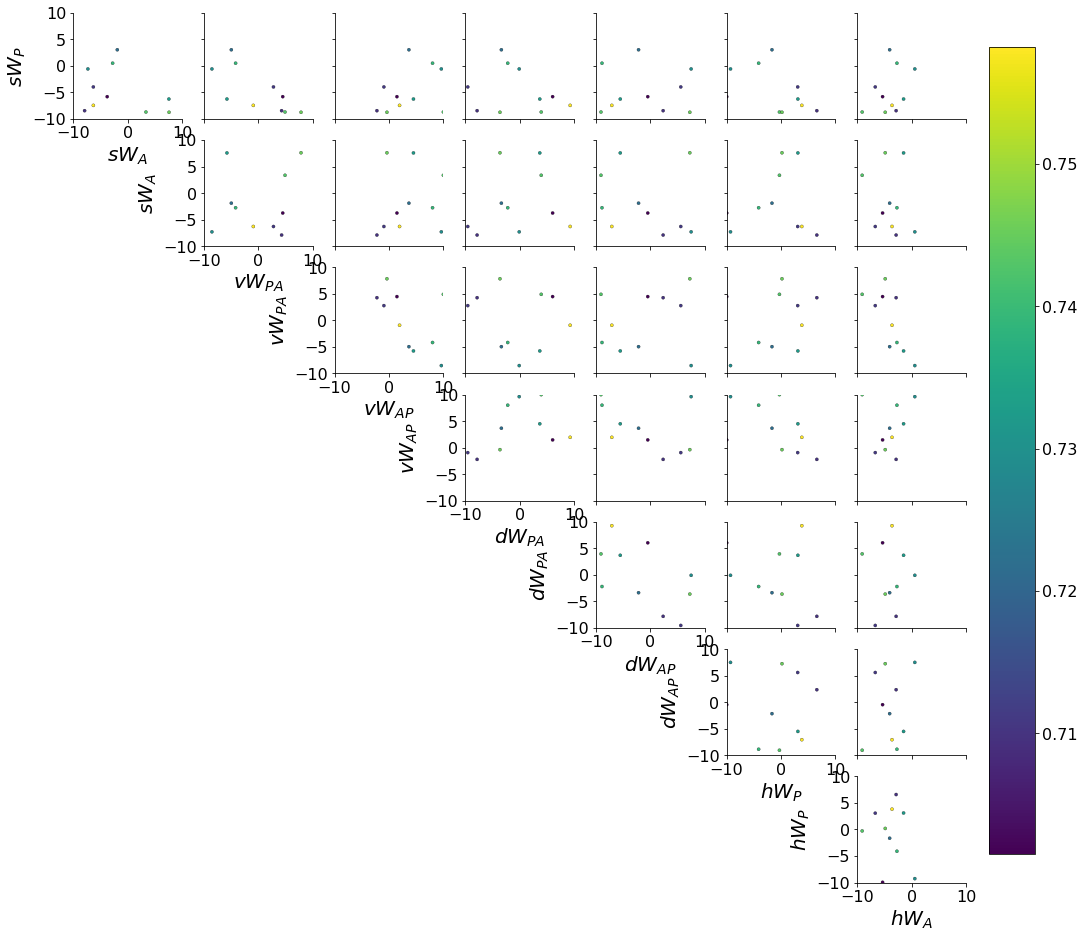

In [198]:
fig = pairplot(z[:num_plot], np.arange(8), z_labels,
               fontsize=fontsize, figsize=(16,16),
               lb=_lb, ub=_ub, c = T_x[:,0])

[0.7451682  0.26620054]
c 1


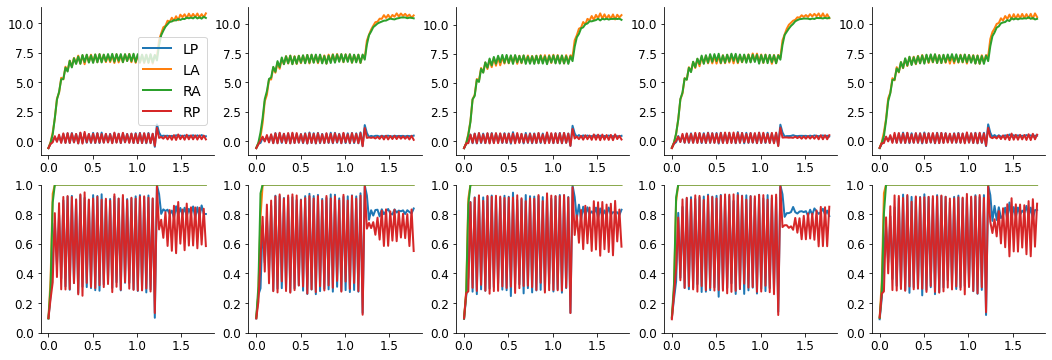

c 2


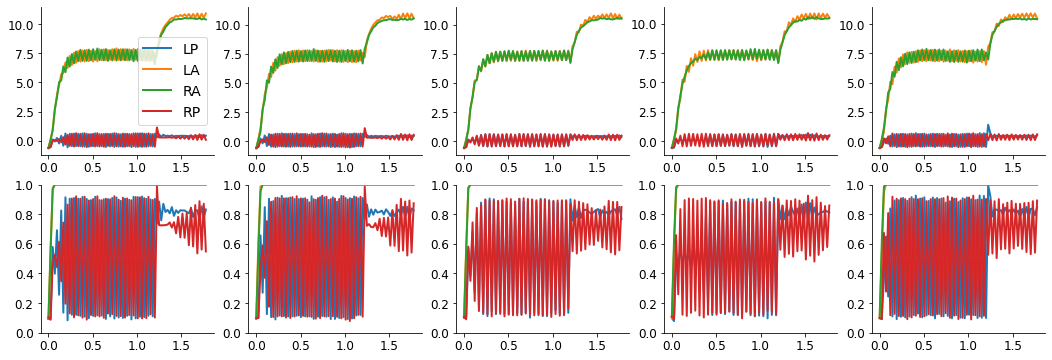

[0.71099067 0.22547942]
c 1


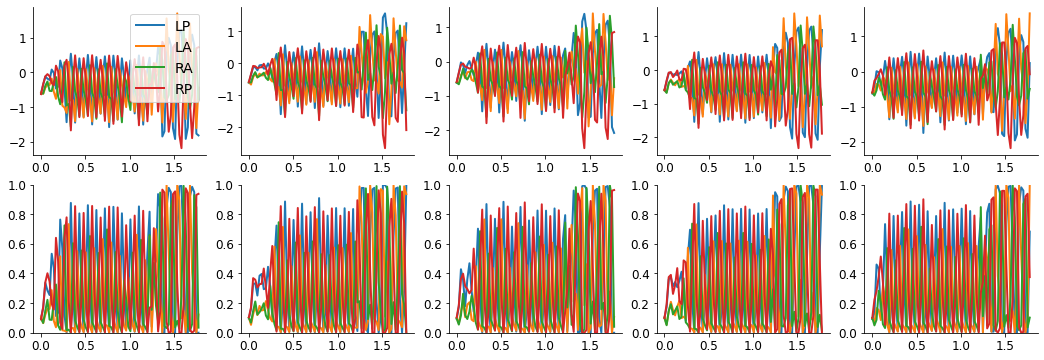

c 2


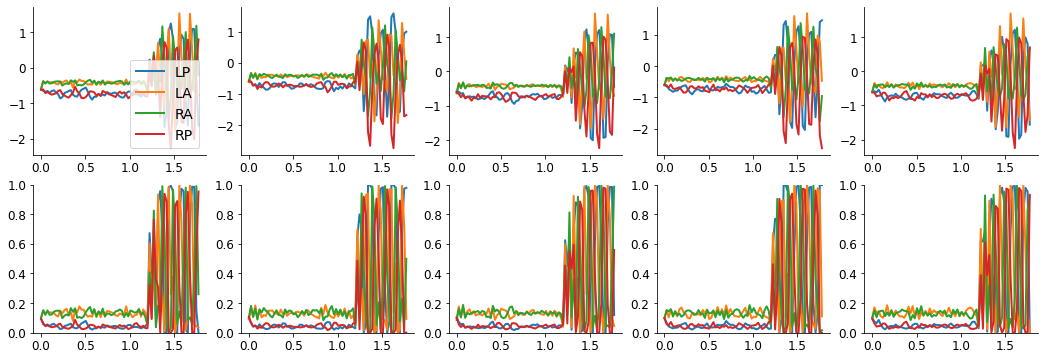

[0.72187376 0.2874834 ]
c 1


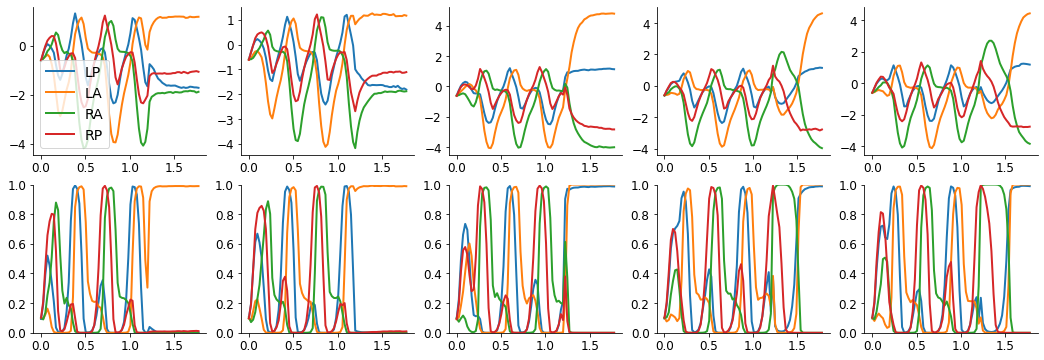

c 2


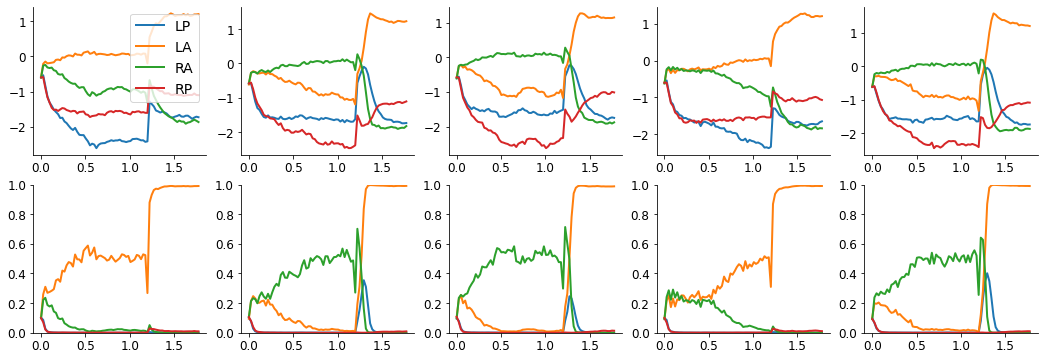

[0.70154524 0.27332485]
c 1


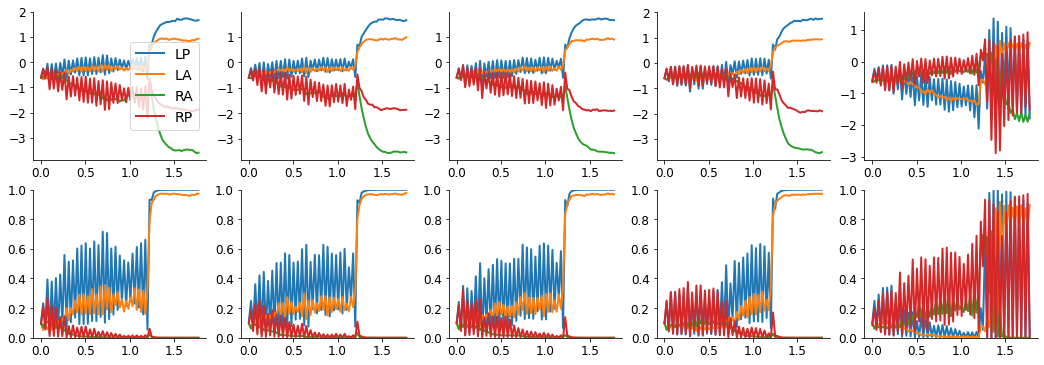

c 2


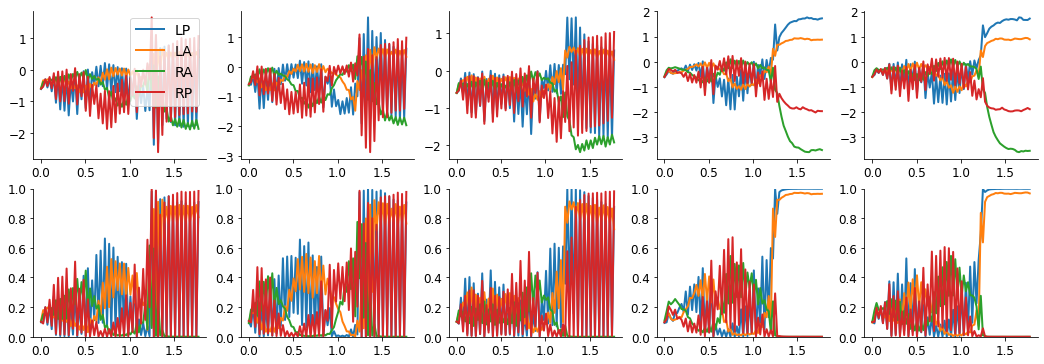

[0.709811  0.2911472]
c 1


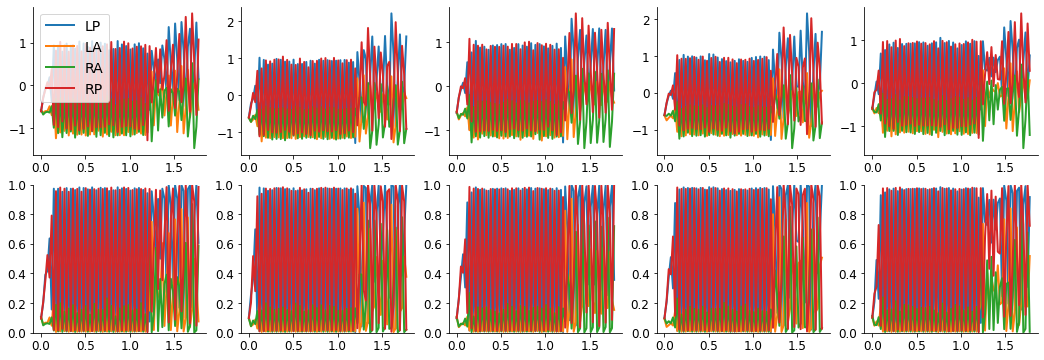

c 2


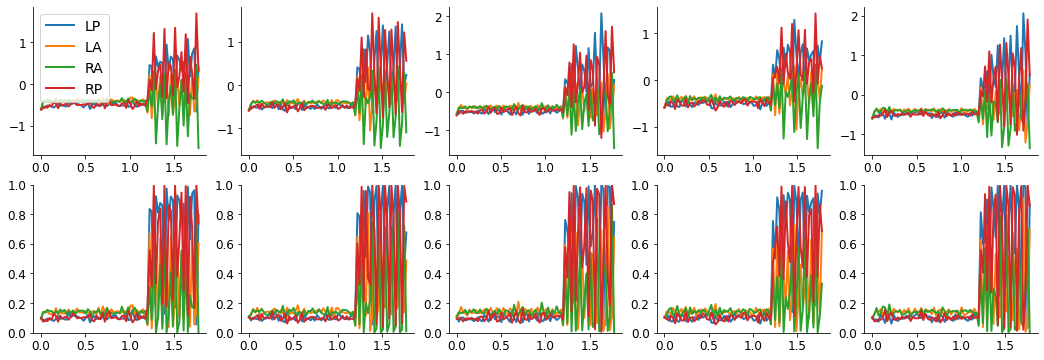

In [199]:
u_t, v_t = SC_sim_wrap(z)
neuron_labels = ['LP', 'LA', 'RA', 'RP']
J = 5
for m in range(5):
    print(T_x[m])
    for c in range(2):
        print('c', c+1)
        fig, axs = plt.subplots(2, J, figsize=(18,6))
        for j in range(J):
            for i in range(4):
                axs[0,j].plot(t, u_t[:,m,c,i,j], label=neuron_labels[i])
                axs[1,j].plot(t, v_t[:,m,c,i,j], label=neuron_labels[i])
                axs[1,j].set_ylim([0,1])
                
        axs[0,0].legend()
        plt.show()


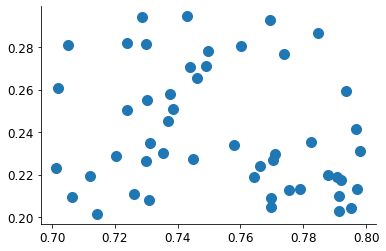

In [100]:
plt.scatter(T_x[:,0], T_x[:,1])

In [101]:
T_xs = []
N_samp = 250
for i in range(N_samp):
    T_xs.append(model.eps(z))
    
T_xs = np.stack(T_xs, axis=0)
print(T_xs.shape)

(250, 50, 2)


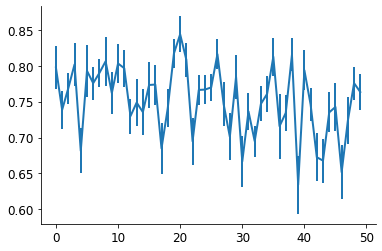

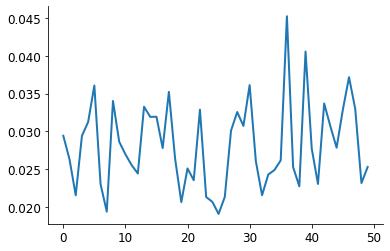

In [102]:
p_mean = np.mean(T_xs, axis=0)
p_std = np.std(T_xs, axis=0)
plt.figure()
plt.errorbar(np.arange(p_mean.shape[0]), p_mean[:,0], p_std[:,0])
plt.show()

plt.figure()
plt.plot(np.arange(p_mean.shape[0]), p_std[:,0])
plt.show()